# Predicting the price of Bitcoin, intro to LSTM


Importing the necessary libraries

In [1]:
#data manipulation libraries
import numpy as np 
import pandas as pd 
#data visualization libraries
from matplotlib import pyplot as plt 
import seaborn as sns

## Data Exploration

Let’s first load the dataset with Python and take a first look:

The dataset has been downloaded from : https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD . You can download your updated dataset from here.

In [3]:
#reading the csv file
data = pd.read_csv('/content/BTC-USD.csv')
#sorting the dataset with respect to Date.
data = data.sort_values('Date')
#Let's have a sneek peek of the dataset.
data.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


In [4]:
data.tail()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
2750,BTC,2021-04-13,59853.197242,59998.159913,61219.718613,59428.214749
2751,BTC,2021-04-14,63223.884391,59841.561373,63707.342359,59799.440578
2752,BTC,2021-04-15,62926.557176,63562.673545,64801.787870,61400.283968
2753,BTC,2021-04-16,63346.789035,62987.270179,63850.250735,62094.632914
2754,BTC,2021-04-17,61965.782598,63225.093917,63520.325374,60033.534667


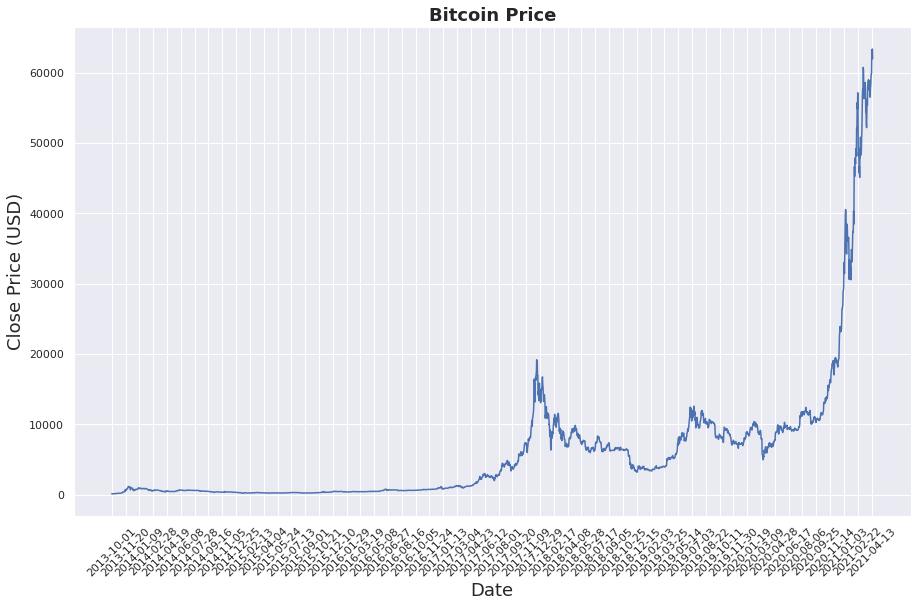

In [ ]:
#Creating a dataframe for Closing Price (USD) column as it's our target variable to predict.
price = data[['Closing Price (USD)']]
#Plotting the price for the historical data of bitcoin
plt.figure(figsize = (15,9))
plt.plot(price)
plt.xticks(range(0, data.shape[0],50), data['Date'].loc[::50],rotation=45)
plt.title("Bitcoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

A simple .info() over our dataframe gives us some useful information, like the number of entries, and the number of Non-Null entries, which in our case are the same, so nothing else to do here.

In [ ]:
#Let's hava a look at the price dataframe
price

,Closing Price (USD)
0,123.654990
1,125.455000
2,108.584830
3,118.674660
4,121.338660
...,...
2750,59853.197242
2751,63223.884391
2752,62926.557176
2753,63346.789035


In [ ]:
#Let's have a look at the summary of our price dataframe
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2755 entries, 0 to 2754
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Closing Price (USD)  2755 non-null   float64
dtypes: float64(1)
memory usage: 123.0 KB


## Data Preparation

### Normalization

The first step we will take to our data is to normalize its values. The goal of normalization is to change the values of numeric columns in the data set to a common scale, without distorting differences in the ranges of values.

For our purposes, we will use MinMaxScaler from the sklearn library

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()#this by default returns the value between 0-10.
norm_data= min_max_scaler.fit_transform(price.values)#fitting these val ues

In [ ]:
norm_data

array([[2.38307842e-04],
       [2.66771807e-04],
       [0.00000000e+00],
       ...,
       [9.93354779e-01],
       [1.00000000e+00],
       [9.78161833e-01]])

Let’s try to compare our values before and after normalizing

In [ ]:
print(f'Real: {price.values[0]}, Normalized: {norm_data[0]}')
print(f'Real: {price.values[500]}, Normalized: {norm_data[500]}')
print(f'Real: {price.values[900]}, Normalized: {norm_data[900]}')

Real: [123.65499], Normalized: [0.00023831]
Real: [223.96716], Normalized: [0.00182457]
Real: [407.473], Normalized: [0.00472639]


### Data split

Splitting the Data into training and testing sets.
Also i am preparing the data for LSTM network.

The responsible for this second part will be our univariate_data function:

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)
  
past_history = 5
future_target = 0
#we need to use 5 days of data to learn to predict the next point in the time series 'future_target'.

TRAIN_SPLIT = int(len(norm_data) * 0.8)#Last index of the 80% data used for training.


x_train, y_train = univariate_data(norm_data,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

x_test, y_test = univariate_data(norm_data,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

By using past_history, we call tell our network that we need to use 5 days of data to learn to predict the next point in the time series future_target.

## Build the model

The next step is to build our model architecture. Finding the right model is an art, and it will take several tries plus experience to find the right layers and hyper-parameters for each one of them.

We won’t go into the details on each layer, there’s enough complexity to write a post for each. But I’ll highlight that the model we built here is fairly simple and pretty standard for this kind of problems, at least in the type of layers used.

In the script above, we create an LSTM model with one LSTM layer of 50 neurons and relu activation functions. You can see the input shape is (1,1) since our data has one time-step with one feature.

In [ ]:
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout

num_units = 64#Number of neurons
learning_rate = 0.0001
activation_function = 'sigmoid'
adam = Adam(lr=learning_rate)
loss_function = 'mse'
batch_size = 5
num_epochs = 250

# Initialize the RNN
model = Sequential()
#In Keras we can simply stack multiple layers on top of each other, for this we need to initialize the model as Sequential().
model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
#This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons.
model.add(Dense(units = 1))#fully conneceted layer


# Compiling the RNN
model.compile(optimizer=adam, loss=loss_function)

Let’s see how our architecture looks like:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Train the model

Now that we have our data ready, and our model compiled, we can start training, and with Keras is as simple as one line of code:

In [ ]:
# Using the training set to train the model
history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=False
)

Epoch 1/250
396/396 [==============================] - 3s 5ms/step - loss: 0.0838 - val_loss: 0.0046
Epoch 2/250
396/396 [==============================] - 2s 4ms/step - loss: 0.0248 - val_loss: 0.0031
Epoch 3/250
396/396 [==============================] - 2s 4ms/step - loss: 0.0226 - val_loss: 0.0067
Epoch 4/250
396/396 [==============================] - 2s 4ms/step - loss: 0.0183 - val_loss: 0.0077
Epoch 5/250
396/396 [==============================] - 2s 4ms/step - loss: 0.0171 - val_loss: 0.0057
Epoch 6/250
396/396 [==============================] - 1s 4ms/step - loss: 0.0148 - val_loss: 0.0066
Epoch 7/250
396/396 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0075
Epoch 8/250
396/396 [==============================] - 2s 4ms/step - loss: 0.0129 - val_loss: 0.0064
Epoch 9/250
396/396 [==============================] - 2s 4ms/step - loss: 0.0124 - val_loss: 0.0054
Epoch 10/250
396/396 [==============================] - 1s 4ms/step - loss: 0.0108 - val_lo

Finding the right hyper-parameters here is also part of the art, however, it is very important that the parameter shuffle is set to False. Our analysis depends completely on the order of the information, if we change the order our results will make no sense at all.

Training for this model is something you can do, even without GPU, the amount of data is very low, and the network architecture is very simple. On more advanced models, and with more granular information, these models can take hours or days to train.

After you finish training, it’s important that we evaluate the result of our training, did we do good? what’s our training loss and validation loss function look like? If something doesn’t look right, then you probably need to go back to the previous steps and play with you hyper-parameters, or maybe even revise your model architecture.

Here is a nice chart you can use to compare both functions:

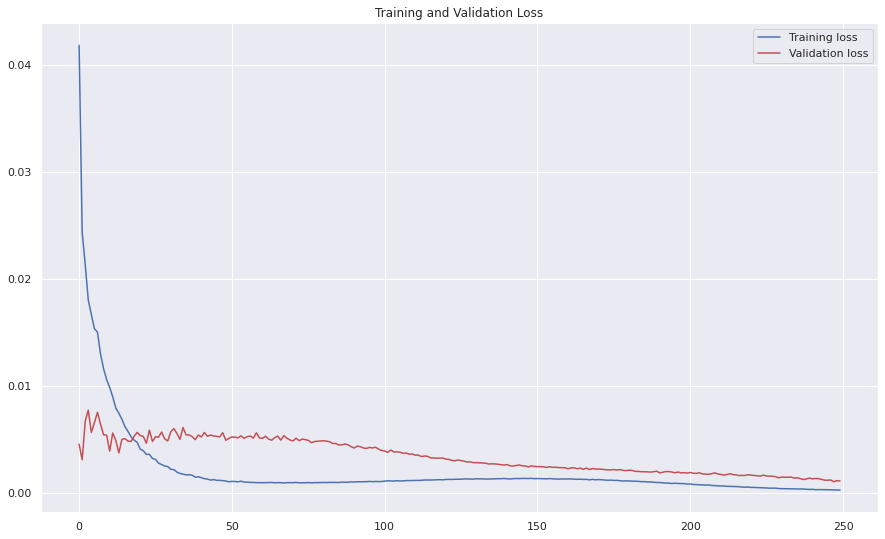

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))


plt.figure(figsize = (15,9))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Prediction
For each of the items we used for the validation, let's now predict them so we can compare how well we did.

With our model now trained, we can start making some predictions and evaluating those predictions to our test data to see how well our model is doing:

[]

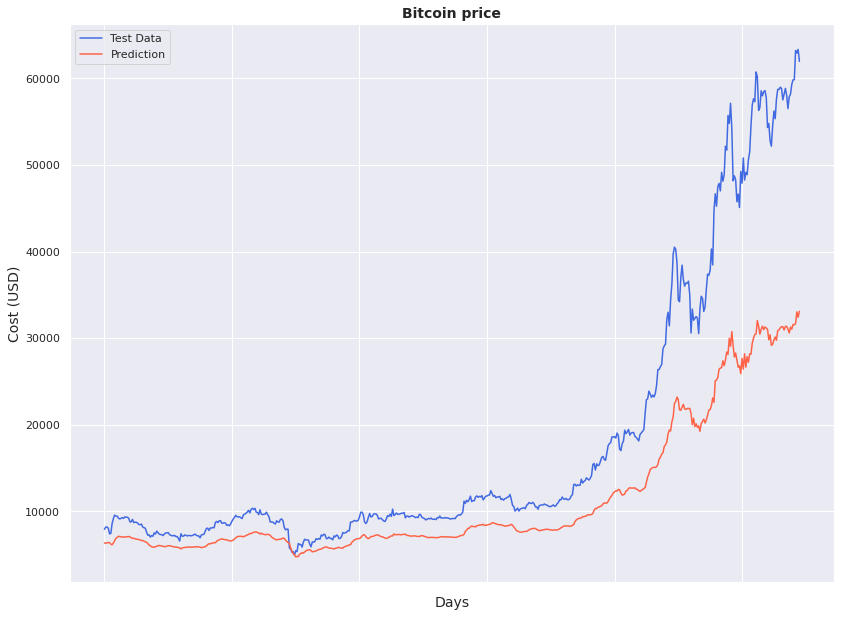

In [ ]:
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))
sns.set(rc={'figure.figsize':(11.7+2,8.27+2)})
ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)